<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Applied-Modeling/blob/master/Final_Lambda_Project_log_transformed_XGBoostregresser_Applied_Modelling_Bhav_DengueAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
#https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/

In [0]:
#Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. 

In [0]:
#Performance metric = mean absolute error

##LIST OF FEATURES:
You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

###City and date indicators
1. city – City abbreviations: sj for San Juan and iq for Iquitos
2. week_start_date – Date given in yyyy-mm-dd format
###NOAA's GHCN daily climate data weather station measurements
1. station_max_temp_c – Maximum temperature
2. station_min_temp_c – Minimum temperature
3. station_avg_temp_c – Average temperature
4. station_precip_mm – Total precipitation
5. station_diur_temp_rng_c – Diurnal temperature range

###PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

6. precipitation_amt_mm – Total precipitation

###NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

7. reanalysis_sat_precip_amt_mm – Total precipitation
8. reanalysis_dew_point_temp_k – Mean dew point temperature
9. reanalysis_air_temp_k – Mean air temperature
10. reanalysis_relative_humidity_percent – Mean relative humidity
11. reanalysis_specific_humidity_g_per_kg – Mean specific humidity
12. reanalysis_precip_amt_kg_per_m2 – Total precipitation
13. reanalysis_max_air_temp_k – Maximum air temperature
14. reanalysis_min_air_temp_k – Minimum air temperature
15. reanalysis_avg_temp_k – Average air temperature
16. reanalysis_tdtr_k – Diurnal temperature range

###Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
17. ndvi_se – Pixel southeast of city centroid
18. ndvi_sw – Pixel southwest of city centroid
19. ndvi_ne – Pixel northeast of city centroid
20. ndvi_nw – Pixel northwest of city centroid

####TARGET VARIABLE = total_cases label for each (city, year, weekofyear)

In [0]:
import sys

In [0]:
#Load train features and labels datasets
train_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_train.csv')

In [0]:
train_features.head()

city  year  ...  station_min_temp_c station_precip_mm
0   sj  1990  ...                20.0              16.0
1   sj  1990  ...                22.2               8.6
2   sj  1990  ...                22.8              41.4
3   sj  1990  ...                23.3               4.0
4   sj  1990  ...                23.9               5.8

[5 rows x 24 columns]

In [0]:
train_features.shape

(1456, 24)

In [0]:
train_labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv')

In [0]:
train_labels.head()

city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6

In [0]:
train_labels.shape

(1456, 4)

In [0]:
#Merge train features and labels datasets

In [0]:
train = pd.merge(train_features, train_labels)

In [0]:
train.head()

city  year  weekofyear  ... station_min_temp_c  station_precip_mm  total_cases
0   sj  1990          18  ...               20.0               16.0            4
1   sj  1990          19  ...               22.2                8.6            5
2   sj  1990          20  ...               22.8               41.4            4
3   sj  1990          21  ...               23.3                4.0            3
4   sj  1990          22  ...               23.9                5.8            6

[5 rows x 25 columns]

In [0]:
train.shape
#city, year and week of year columns are duplicate in train_features and train_labels datasets so the total_cases column is added to the features dataset

(1456, 25)

In [0]:
train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

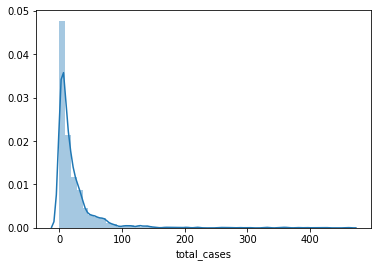

In [0]:
#Distribution of the target
import seaborn as sns
sns.distplot(train['total_cases'])

In [0]:
#The target distribution is skewed

In [0]:
#Find outliers
train['total_cases'].describe()

count    1456.000000
mean       24.675137
std        43.596000
min         0.000000
25%         5.000000
50%        12.000000
75%        28.000000
max       461.000000
Name: total_cases, dtype: float64

In [0]:
#Remove outliers
train = train[(train['total_cases'] >= np.percentile(train['total_cases'], 0.5)) & 
        (train['total_cases'] <= np.percentile(train['total_cases'], 99.5))]  

In [0]:
train.shape

(1448, 25)

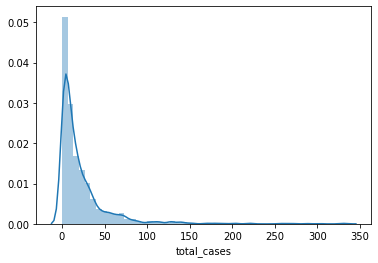

In [0]:
sns.distplot(train['total_cases'])

In [0]:
#Do train, val split
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)
train.shape, val.shape

((1158, 25), (290, 25))

In [0]:
#Load test features dataset (for the competition)
test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv')

In [0]:
test.shape

(416, 24)

In [0]:
#Pandas Profiling
!pip install pandas-profiling==2.*

In [0]:
import pandas_profiling

In [0]:
profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [0]:
#Baseline statistics for the target variable total_cases in train dataset

In [0]:
train['total_cases']. describe()

count    1158.000000
mean       22.301382
std        32.947535
min         0.000000
25%         5.000000
50%        12.000000
75%        27.000000
max       333.000000
Name: total_cases, dtype: float64

In [0]:
#Baseline mean and mean absolute error

In [0]:
guess = train['total_cases'].mean()
print(f'At the baseline, the mean total number of dengue cases in a year is: {guess:.2f}')

At the baseline, the mean total number of dengue cases in a year is: 22.30


In [0]:
#If we had just guessed that the total number of dengue cases was 22.30 for a city in a particular year, we would be off by how much?

In [0]:
from sklearn.metrics import mean_absolute_error

# Arrange y target vectors
target = 'total_cases'
y_train = train[target]
y_val = val[target]

# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train mean absolute error: {mae:.2f} dengue cases per year')

# Test Error
y_pred = [guess] * len(y_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation mean absolute error: {mae:.2f} dengue cases per year')

Mean Baseline (using 0 features)
Train mean absolute error: 19.77 dengue cases per year
Validation mean absolute error: 21.46 dengue cases per year


In [0]:
#we need to convert week_start_date to numeric form uisng pd.to_dateime function
#wrangle function 

def wrangle(X):
  X = X.copy()
       
    # Convert week_start_date to numeric form
  X['week_start_date'] = pd.to_datetime(X['week_start_date'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['week_start_date'].dt.year
  X['month_recorded'] = X['week_start_date'].dt.month
  #X['day_recorded'] = X['week_start_date'].dt.day
  X = X.drop(columns='week_start_date')
  X = X.drop(columns='year')
  X = X.drop(columns='station_precip_mm')

#I engineered few features which represent standing water, high risk feature for mosquitos

  #1. X['standing water feature 1'] = X['station_precip_mm'] / X['station_max_temp_c']
  X['total satellite vegetation index of city'] = X['ndvi_se'] + X['ndvi_sw'] + X['ndvi_ne'] + X['ndvi_nw']
 
    #2. standing water feature 2 = 'NOAA GCN precipitation amount in kg per m2 reanalyzed' * (total vegetation, sum of all 4 parts of the city)
  X['standing water feature 2'] = X['reanalysis_precip_amt_kg_per_m2'] * X['total satellite vegetation index of city'] 
    #3. standing water feature 3: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'}
  X['standing water feature 3'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent']   
    #4. standing water feature 4: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'} * (total vegetation)
  X['standing water feature 4'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent'] * X['total satellite vegetation index of city']  
    # 5. standing water feature 5: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} / 'NOAA GCN max air temp reanalyzed'
  X['standing water feature 5'] = X['reanalysis_precip_amt_kg_per_m2'] / X['reanalysis_max_air_temp_k']
    #6. standing water feature 6 (most imp): ['NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'} * (total vegetation)]/['NOAA GCN max air temp reanalyzed']
  X['standing water feature 6'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent'] * X['total satellite vegetation index of city'] / X['reanalysis_max_air_temp_k']
    
    # return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
train.head().T

486   ...      1135
city                                             sj  ...        iq
weekofyear                                       35  ...        18
ndvi_ne                                         NaN  ...   0.27884
ndvi_nw                                     -0.0331  ...  0.163767
ndvi_se                                    0.210657  ...  0.191183
ndvi_sw                                      0.1876  ...  0.326629
precipitation_amt_mm                          30.98  ...     65.82
reanalysis_air_temp_k                       300.459  ...   297.127
reanalysis_avg_temp_k                       300.436  ...   297.829
reanalysis_dew_point_temp_k                 296.896  ...   296.709
reanalysis_max_air_temp_k                     302.7  ...     303.5
reanalysis_min_air_temp_k                     299.1  ...     293.6
reanalysis_precip_amt_kg_per_m2               25.74  ...    133.17
reanalysis_relative_humidity_percent        81.0029  ...   97.8086
reanalysis_sat_precip_amt_mm                  30.98  ...     65.82
reanalysis_specific_humidity_g_per_kg         18.41  ...     18.34
reanalysis_tdtr_k                           1.98571  ...   5.02857
station_avg_temp_c                          28.1857  ...   27.5333
station_diur_temp_rng_c                     7.02857  ...   8.66667
station_max_temp_c                             32.8  ...      32.9
station_min_temp_c                             23.9  ...      22.6
total_cases                                      21  ...         7
year_recorded                                  1999  ...      2004
month_recorded                                    9  ...         4
total satellite vegetation index of city        NaN  ...  0.960419
standing water feature 2                        NaN  ...   127.899
standing water feature 3                    2085.01  ...   13025.2
standing water feature 4                        NaN  ...   12509.6
standing water feature 5                  0.0850347  ...  0.438781
standing water feature 6                        NaN  ...   41.2178

[30 rows x 5 columns]

In [0]:
#Seaborn correlation coefficient heat map

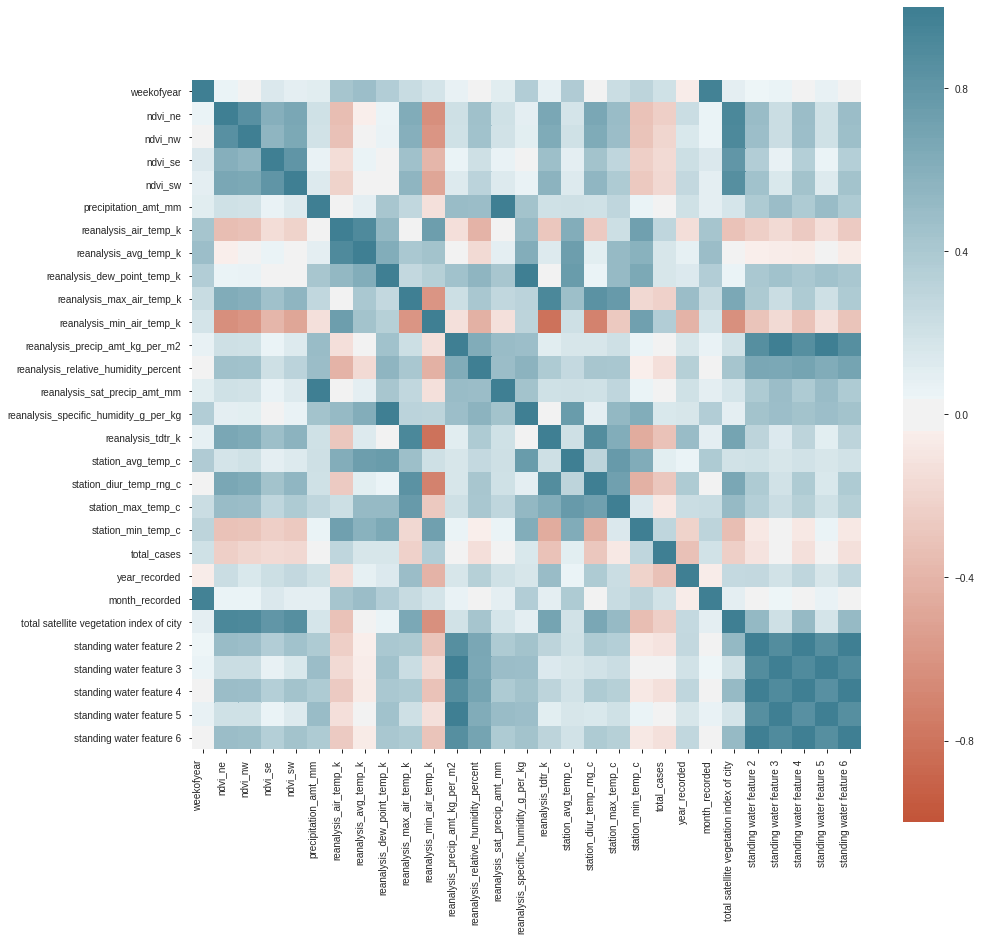

In [0]:
#Correlation coefficients heatmap on train dataset
import seaborn as sns
import matplotlib.pyplot as plt

corr = train.corr()
plt.figure(figsize = (15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [0]:
#There appears good relationship between total cases and variables: 1) reanalysis_air_temp_k (Mean air temperature by satellite cliamte forecast system),
# 2) reanalysis_min_air_temp_k (Minimum air temperature by satellite climate forecast system), station_min_temp_c (minimum temp recorded at weather station)

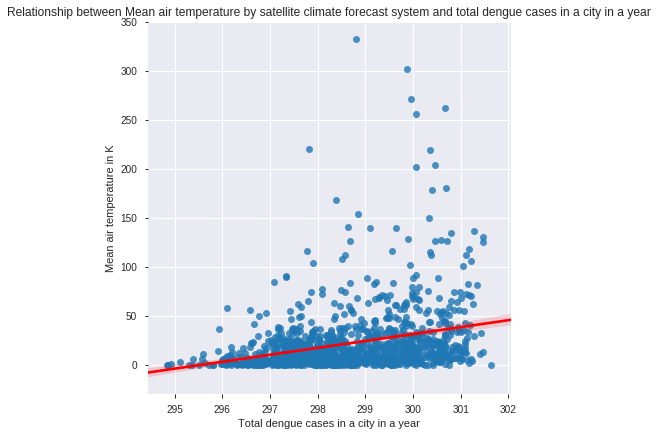

In [0]:
#Linear Regression Plot number 1
sns.lmplot(x ='reanalysis_air_temp_k', y ='total_cases', data = train, height=6, line_kws={'color': 'red'})
plt.xlabel('Total dengue cases in a city in a year')
plt.ylabel('Mean air temperature in K')
plt.title('Relationship between Mean air temperature by satellite climate forecast system and total dengue cases in a city in a year')
plt.show()

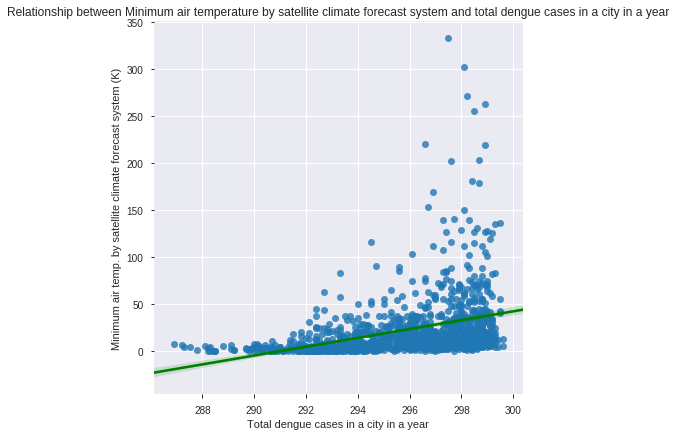

In [0]:
#Linear Regression Plot number 2
sns.lmplot(x ='reanalysis_min_air_temp_k', y ='total_cases', data = train, height=6, line_kws={'color': 'green'})
plt.xlabel('Total dengue cases in a city in a year')
plt.ylabel('Minimum air temp. by satellite climate forecast system (K)')
plt.title('Relationship between Minimum air temperature by satellite climate forecast system and total dengue cases in a city in a year')
plt.show()

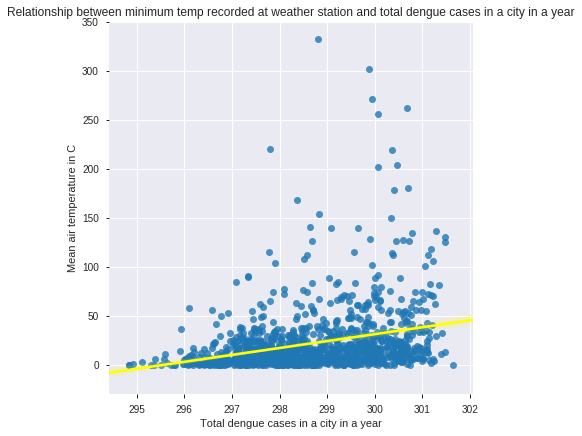

In [0]:
#Linear Regression Plot number 3
sns.lmplot(x ='reanalysis_air_temp_k', y ='total_cases', data = train, height=6, line_kws={'color': 'yellow'})
plt.xlabel('Total dengue cases in a city in a year')
plt.ylabel('Mean air temperature in C')
plt.title('Relationship between minimum temp recorded at weather station and total dengue cases in a city in a year')
plt.show()

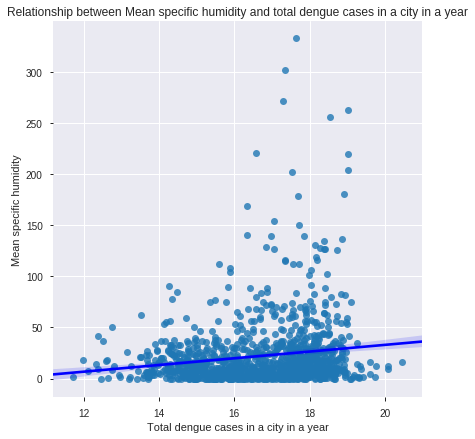

In [0]:
#Linear Regression Plot number 4
sns.lmplot(x ='reanalysis_specific_humidity_g_per_kg', y ='total_cases', data = train, height=6, line_kws={'color': 'blue'})
plt.xlabel('Total dengue cases in a city in a year')
plt.ylabel('Mean specific humidity')
plt.title('Relationship between Mean specific humidity and total dengue cases in a city in a year')
plt.show()

In [0]:
#Before we build the model to train on train dataset, log transform target variable due to skew

In [0]:
import numpy as np
target_log = np.log1p(train['total_cases'])

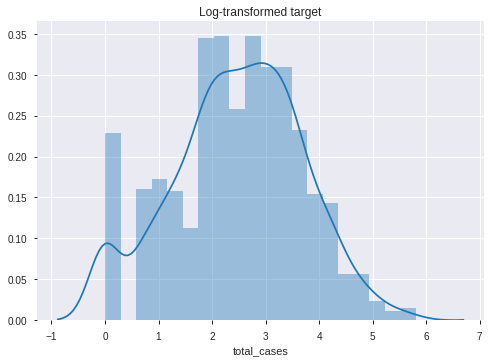

In [0]:
sns.distplot(target_log)
plt.title('Log-transformed target');

In [0]:
target_log_series = pd.Series(target_log)

In [0]:
train = train.assign(log_total_cases = target_log_series)

In [0]:
#drop total_cases target column while training the model
train = train.drop(columns='total_cases')

In [0]:
#Do the same log transformation with validation dataset
target_log_val = np.log1p(val['total_cases'])

In [0]:
target_log_val_series = pd.Series(target_log_val)

In [0]:
val = val.assign(log_total_cases = target_log_val_series)

In [0]:
val = val.drop(columns='total_cases')

In [0]:
#Define target and features

In [0]:
# The status_group column is the target
target = 'log_total_cases'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


In [0]:
pip install category_encoders

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import model_selection, preprocessing

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

In [0]:
#fit on X_train, y_train
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=200, n_jobs=-1,
                              nthread=None, objective='r

In [0]:
#predict on X_val
y_pred = pipeline.predict(X_val)

In [0]:

from sklearn.metrics import r2_score
print('Gradient Boosting Validation R^2', r2_score(y_val, y_pred))

Gradient Boosting Validation R^2 0.7363600436127161


In [0]:
#The Validation R2 score is good= 73.6%. So, our model explains 73.6% of variance in the validation dataset.

In [0]:
print('Gradient Boosting Validation Mean Absolute Error (log transformed)', mean_absolute_error(y_val, y_pred))

Gradient Boosting Validation Mean Absolute Error (log transformed) 0.48756055910420154


In [0]:
#Transform y_pred back to original units from log transformed
y_pred_original = np.expm1(y_pred)

In [0]:
y_val_original = np.expm1(y_val)

In [0]:
print('Gradient Boosting Validation Mean Absolute Error (log transformed)', mean_absolute_error(y_val_original, y_pred_original))

Gradient Boosting Validation Mean Absolute Error (log transformed) 11.279563823541434


In [0]:
#Thus the MAE is significantly reduced after Gradient Boosting Model and including the features from 21.46 cases/year to 11.28 cases/year

In [0]:
#Feature importances

In [0]:
encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

encoded.shape

(1158, 30)

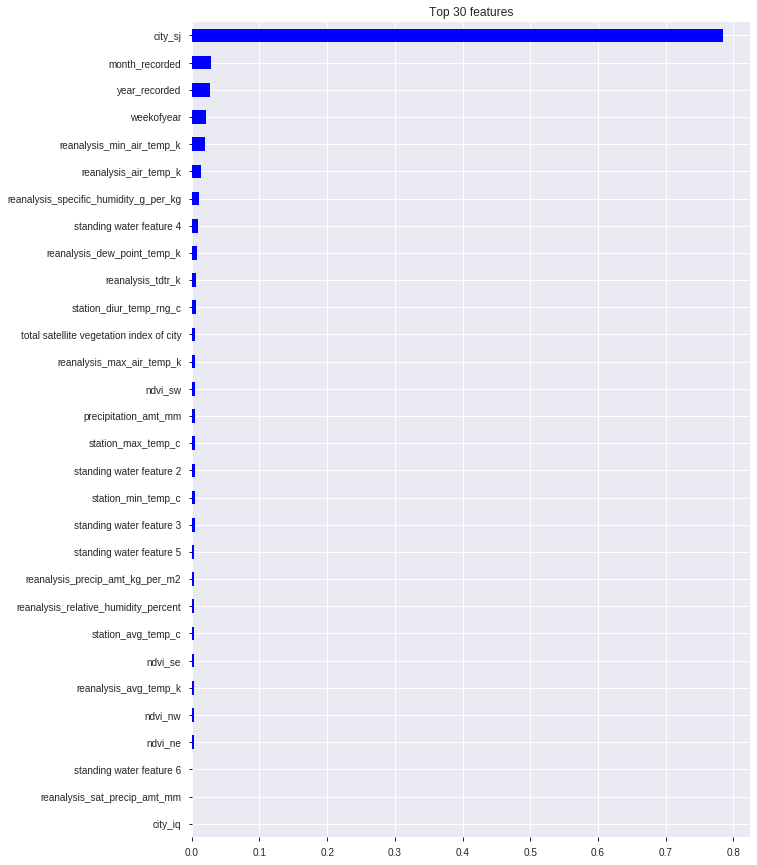

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 30
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

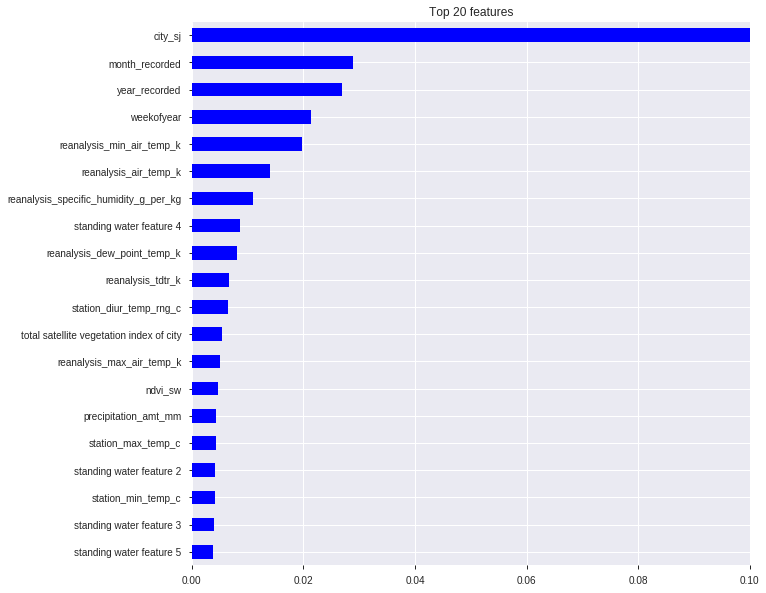

In [0]:
#Limit plot x axis size to study other features better
# Get feature importances
rf = pipeline.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10, n/2))
plt.xlim(0, 0.1)
plt.title(f'Top {n} features')

importances.sort_values()[-n:].plot.barh(color='blue');

In [0]:
#renalysis_min_air_temp_k and renalysis_air_temp_k are here also among top ranking features similar to our earlier pairwide exploration

In [0]:
#renalysis_specific_humidity_g_per_kg (Mean specific humidity) measured by climate forecasting system also has significant relationship with the no. of dengue cases.


In [0]:
#Permutation Importance with Elif Library
pip install eli5

     |████████████████████████████████| 112kB 10.3MB/s 


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [0]:
#Eli5 doesn't work with pipelines
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model,
    scoring= 'neg_median_absolute_error',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)
permuter.feature_importances_
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
#Min air temperature, mean dew point temp and station average temp are the top 3 weather features with a relationship to number of dengue cases per year in a city.